In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Loading the initial data
data = pd.DataFrame({
    'customer_id': [15634602, 15647311, 15619304, 15701354, 15737888],
    'credit_score': [619, 608, 502, 699, 850],
    'country': ['France', 'Spain', 'France', 'France', 'Spain'],
    'gender': ['Female', 'Female', 'Female', 'Female', 'Female'],
    'age': [42, 41, 42, 39, 43],
    'tenure': [2, 1, 8, 1, 2],
    'balance': [0, 83807.86, 159660.8, 0, 125510.82],
    'products_number': [1, 1, 3, 2, 1],
    'credit_card': [1, 0, 1, 0, 1],
    'active_member': [1, 1, 0, 0, 1],
    'estimated_salary': [101348.88, 112542.58, 113931.57, 93826.63, 79084.1],
    'churn': [1, 0, 1, 0, 0]
})

# Initial exploration
print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nData Info:")
print(data.info())



Dataset Shape: (5, 12)

First few rows:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Dat

In [2]:
def preprocess_data(df):
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle categorical variables through one-hot encoding
    df_processed = pd.get_dummies(df_processed, columns=['country', 'gender'])
    
    # Scale numerical features
    scaler = StandardScaler()
    numerical_columns = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
    df_processed[numerical_columns] = scaler.fit_transform(df_processed[numerical_columns])
    
    return df_processed

# Apply preprocessing
processed_data = preprocess_data(data)
print("Processed data columns:", processed_data.columns.tolist())



Processed data columns: ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn', 'country_France', 'country_Spain', 'gender_Female']



Number of anomalies detected (Z-score): 0


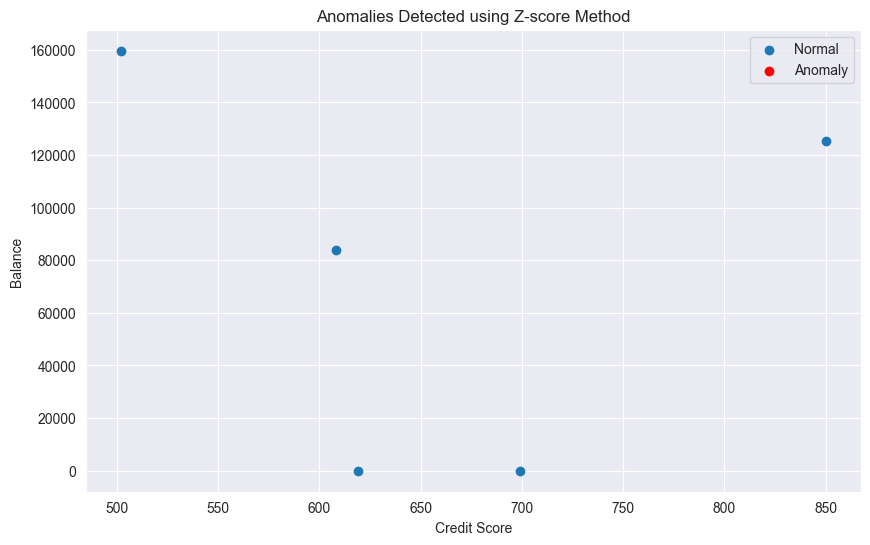

In [3]:
def detect_anomalies_zscore(df, threshold=3):
    numerical_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
    anomalies = np.zeros(len(df))
    
    for column in numerical_cols:
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        anomalies = np.logical_or(anomalies, z_scores > threshold)
    
    return anomalies

# Detect anomalies using Z-score
zscore_anomalies = detect_anomalies_zscore(processed_data)
print("\nNumber of anomalies detected (Z-score):", sum(zscore_anomalies))

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(data['credit_score'][~zscore_anomalies], 
           data['balance'][~zscore_anomalies], 
           label='Normal')
plt.scatter(data['credit_score'][zscore_anomalies], 
           data['balance'][zscore_anomalies], 
           color='red', 
           label='Anomaly')
plt.xlabel('Credit Score')
plt.ylabel('Balance')
plt.title('Anomalies Detected using Z-score Method')
plt.legend()
plt.show()



In [4]:
from sklearn.ensemble import IsolationForest

def detect_anomalies_iforest(df):
    # Initialize and fit Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    
    # Exclude non-numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    anomalies = iso_forest.fit_predict(df[numeric_cols])
    
    # Convert to boolean (True for anomalies)
    return anomalies == -1

# Detect anomalies using Isolation Forest
iforest_anomalies = detect_anomalies_iforest(processed_data)
print("\nNumber of anomalies detected (Isolation Forest):", sum(iforest_anomalies))




Number of anomalies detected (Isolation Forest): 1


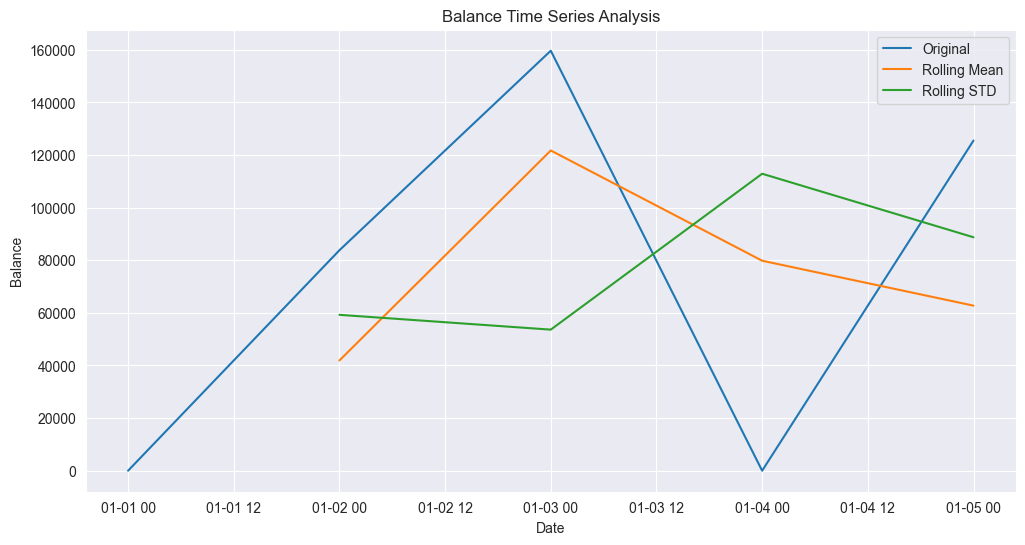

In [5]:
# Create a time series from balance data
dates = pd.date_range(start='2024-01-01', periods=len(data), freq='D')
time_series = pd.Series(data['balance'].values, index=dates)

# Calculate basic statistics
rolling_mean = time_series.rolling(window=2).mean()
rolling_std = time_series.rolling(window=2).std()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling STD')
plt.title('Balance Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

